In [1]:
%matplotlib inline
from IPython.display import clear_output

import gc
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from tqdm import tqdm

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras import initializers
import sys
sys.path.append('/home/art/Programming/artlibs')
from artiom_convenience_functions import * 
from videorecorder import save_to_video, execute_at_exit



In [2]:
def s(img):
    plt.imshow(
    img.reshape(
    N_DIM, N_DIM), cmap='gray')

In [3]:
N_DIM = 28
faces = np.fromfile(f"girls_img_{N_DIM}x{N_DIM}.bin", dtype="uint8").reshape(-1, N_DIM, N_DIM) / 255

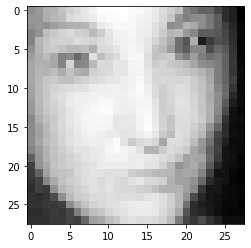

In [4]:
s(faces[2])

# Face generator

In [5]:
inputs = keras.Input(shape=(100))
x = Dense(100, activation='elu')(inputs)
#x = Dropout(0.2)(x)
x = Dense(3000, activation='sigmoid')(x)

x = Dense(N_DIM ** 2, activation='sigmoid')(x)
outputs = Reshape((N_DIM, N_DIM))(x)
face_gen = keras.Model(inputs=inputs, outputs=outputs, name="face_generator")

face_gen.compile(

    optimizer=keras.optimizers.Adam(0.00001),
    metrics=["accuracy"],
)


# policeman 

In [6]:
shape=(N_DIM, N_DIM)

In [7]:
inputs = keras.Input(shape=(N_DIM, N_DIM, 1))

x = Conv2D(30, (3, 3))(inputs)
x = MaxPool2D((3, 3))(x)

x = Conv2D(308, (3, 3))(x)
x = MaxPool2D((3, 3))(x)
# x = Conv2D(308, (3, 3))(x)
# x = MaxPool2D((3, 3))(x)


x = Flatten()(x)
x = Dense(1300, activation='sigmoid')(x)


outputs = Dense(1, activation='sigmoid')(x)
policeman = keras.Model(inputs=inputs, outputs=outputs, name="policeman")

In [8]:

policeman.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(0.00001),
    metrics=["accuracy"],
)

# Среда

In [9]:
policeman.trainable = False
inputs = keras.Input(shape=(100))
x = face_gen(inputs)
outputs = policeman(x) 
env_model = keras.Model(inputs=inputs, outputs=outputs, name="face_generator")

In [10]:

env_model.compile( loss="binary_crossentropy" 
)

In [11]:
env_model.summary()

Model: "face_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 face_generator (Functional)  (None, 28, 28)           2665884   
                                                                 
 policeman (Functional)      (None, 1)                 1687969   
                                                                 
Total params: 4,353,853
Trainable params: 2,665,884
Non-trainable params: 1,687,969
_________________________________________________________________


1/1 [==============================] - 3s 3s/step


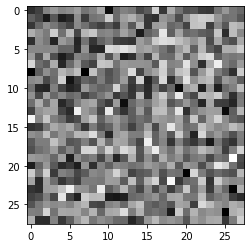

In [12]:
s(
    face_gen.predict(
        np.random.random(size=100).astype("float32").reshape(1, 100)
    ).reshape(N_DIM, N_DIM))

# Учим полицейского

In [13]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

In [14]:
faces_drawn_from_seeds = face_gen.predict(seeds)

10/10 [==============================] - 0s 1ms/step


In [15]:

indices = np.random.randint(0, len(faces), size=N)
real_faces = faces[indices]

In [16]:
X = np.concatenate([faces_drawn_from_seeds, real_faces])
X.shape

(628, 28, 28)

In [17]:
Y = np.zeros(
N * 2)

Y[N:] = 1

In [18]:
Y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

1.0


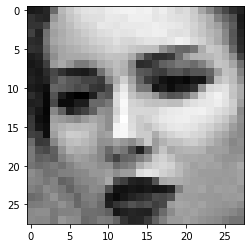

In [19]:
x, y = X[ind:=np.random.randint(0, len(X))],   Y[ind]
print(y)
s(x)

In [20]:
policeman.fit(X, Y, epochs=1, shuffle=1)
policeman.evaluate(X, Y)

20/20 [==============================] - 0s 2ms/step - loss: 0.7083 - accuracy: 0.5000


[0.7082710266113281, 0.5]

# Теперь запускаем срелу

In [21]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

ones = np.ones(len(seeds), dtype="float32").reshape(-1, 1)


In [22]:
ones.shape

(314, 1)

In [23]:

seeds[0]

array([0.20781794, 0.4495932 , 0.9046855 , 0.03283113, 0.5202029 ,
       0.60582334, 0.11736754, 0.02668926, 0.9345587 , 0.90917104,
       0.09031423, 0.40605232, 0.03847915, 0.02295754, 0.9440601 ,
       0.53895634, 0.38794473, 0.7573172 , 0.7269619 , 0.1861127 ,
       0.39279112, 0.91439205, 0.07378923, 0.510704  , 0.8957131 ,
       0.69533086, 0.06906334, 0.00836008, 0.6831974 , 0.12490164,
       0.86189646, 0.0791019 , 0.1500804 , 0.8555702 , 0.74964786,
       0.9315219 , 0.22083941, 0.26401058, 0.08615263, 0.5522678 ,
       0.46055552, 0.8048523 , 0.14588936, 0.29143438, 0.2908853 ,
       0.21272518, 0.06181178, 0.31387743, 0.3330002 , 0.0819077 ,
       0.5056015 , 0.37802255, 0.28866217, 0.06582273, 0.5608602 ,
       0.30388978, 0.68669367, 0.939297  , 0.09885035, 0.7972791 ,
       0.39213824, 0.31499   , 0.17853844, 0.7370993 , 0.9357819 ,
       0.816223  , 0.4832076 , 0.2464153 , 0.10527594, 0.44417778,
       0.8265796 , 0.40651882, 0.08029031, 0.66272014, 0.30700

In [24]:
env_model.fit(seeds, ones, shuffle=1, epochs=1)

10/10 [==============================] - 1s 11ms/step - loss: 0.5157


# В цикле

In [25]:
faces_drawn_from_seeds[0]

array([[0.2813103 , 0.3463715 , 0.5271747 , 0.59047574, 0.541536  ,
        0.5599217 , 0.6092508 , 0.4913835 , 0.5329217 , 0.64477104,
        0.19096735, 0.4527261 , 0.50818986, 0.5035272 , 0.3700369 ,
        0.41358146, 0.76035064, 0.31965685, 0.6542788 , 0.48613006,
        0.38711232, 0.39069042, 0.32971862, 0.31839955, 0.49225807,
        0.59572405, 0.49530497, 0.45421496],
       [0.42056343, 0.3689726 , 0.2232303 , 0.40831548, 0.2449941 ,
        0.2758025 , 0.55535686, 0.3356985 , 0.48886746, 0.5073411 ,
        0.75469244, 0.46649602, 0.6149009 , 0.66367954, 0.56134754,
        0.31301042, 0.29213074, 0.59262794, 0.5330261 , 0.3822613 ,
        0.5648321 , 0.7051329 , 0.7499044 , 0.7391959 , 0.5903258 ,
        0.48138583, 0.5013331 , 0.40610936],
       [0.30945185, 0.44761425, 0.551336  , 0.48932317, 0.41100127,
        0.34995818, 0.5456516 , 0.48695612, 0.39273012, 0.3273631 ,
        0.41570878, 0.32153794, 0.57869136, 0.407251  , 0.6773635 ,
        0.31213245, 0.6040

In [26]:
from importlib import reload

from videorecorder import get_new_cv2_imshow
from videorecorder import save_to_video, execute_at_exit

reload(sys.modules['videorecorder'])
reload(sys.modules['cv2'])
my_imshow = get_new_cv2_imshow(cv2.imshow, video_frame_rate=1,
                                redraw_only_every_nth_frame=1,
                                #last_frame_meditation_time_sec=3,
                                #fading_out_time_sec=5)
                               )

In [27]:

cv2.destroyAllWindows()
from importlib import reload

reload(sys.modules['videorecorder'])
reload(sys.modules['cv2'])
#from videorecorder import save_to_video, execute_at_exit
from artiom_convenience_functions import *

from videorecorder import get_new_cv2_imshow
my_imshow = get_new_cv2_imshow(cv2.imshow, video_frame_rate=1,
                                redraw_only_every_nth_frame=1,
                                #last_frame_meditation_time_sec=3,
                                #fading_out_time_sec=5)
                               )




key = None
while key not in (27,):
    N = 209
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)
    faces_drawn_from_seeds = face_gen.predict(seeds, verbose=0)

    
    
    best_ind = np.argmax(policeman.predict(faces_drawn_from_seeds, verbose=0).reshape(-1))
    my_imshow("result", uint8_normalized(cv2.cvtColor(resize(faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
                               interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB)))
#     save_to_video((faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
#                                interpolation=cv2.INTER_NEAREST))
    key = cv2.waitKey(1)

    indices = np.random.randint(0, len(faces), size=N)
    real_faces = faces[indices]
    X = np.concatenate([faces_drawn_from_seeds, real_faces])
    Y = np.zeros(
    N * 2)

    Y[N:] = 1


    policeman.fit(X, Y, epochs=59, shuffle=1, verbose=0)
    policeman.evaluate(X, Y, verbose=0)






    N = 200
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

    ones = np.ones(len(seeds)).reshape(-1, 1)
    env_model.fit(seeds, ones, shuffle=1, epochs=1, verbose=0)
    
execute_at_exit()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Saving video for you! See you soon!


In [28]:
cv2.cvtColor(resize(faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
                               interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB)

array([[[0.1062253 , 0.1062253 , 0.1062253 ],
        [0.1062253 , 0.1062253 , 0.1062253 ],
        [0.1062253 , 0.1062253 , 0.1062253 ],
        ...,
        [0.51796055, 0.51796055, 0.51796055],
        [0.51796055, 0.51796055, 0.51796055],
        [0.51796055, 0.51796055, 0.51796055]],

       [[0.1062253 , 0.1062253 , 0.1062253 ],
        [0.1062253 , 0.1062253 , 0.1062253 ],
        [0.1062253 , 0.1062253 , 0.1062253 ],
        ...,
        [0.51796055, 0.51796055, 0.51796055],
        [0.51796055, 0.51796055, 0.51796055],
        [0.51796055, 0.51796055, 0.51796055]],

       [[0.1062253 , 0.1062253 , 0.1062253 ],
        [0.1062253 , 0.1062253 , 0.1062253 ],
        [0.1062253 , 0.1062253 , 0.1062253 ],
        ...,
        [0.51796055, 0.51796055, 0.51796055],
        [0.51796055, 0.51796055, 0.51796055],
        [0.51796055, 0.51796055, 0.51796055]],

       ...,

       [[0.5064733 , 0.5064733 , 0.5064733 ],
        [0.5064733 , 0.5064733 , 0.5064733 ],
        [0.5064733 , 0